## PART1 : Image Cartoonification

Processing nelson.webp


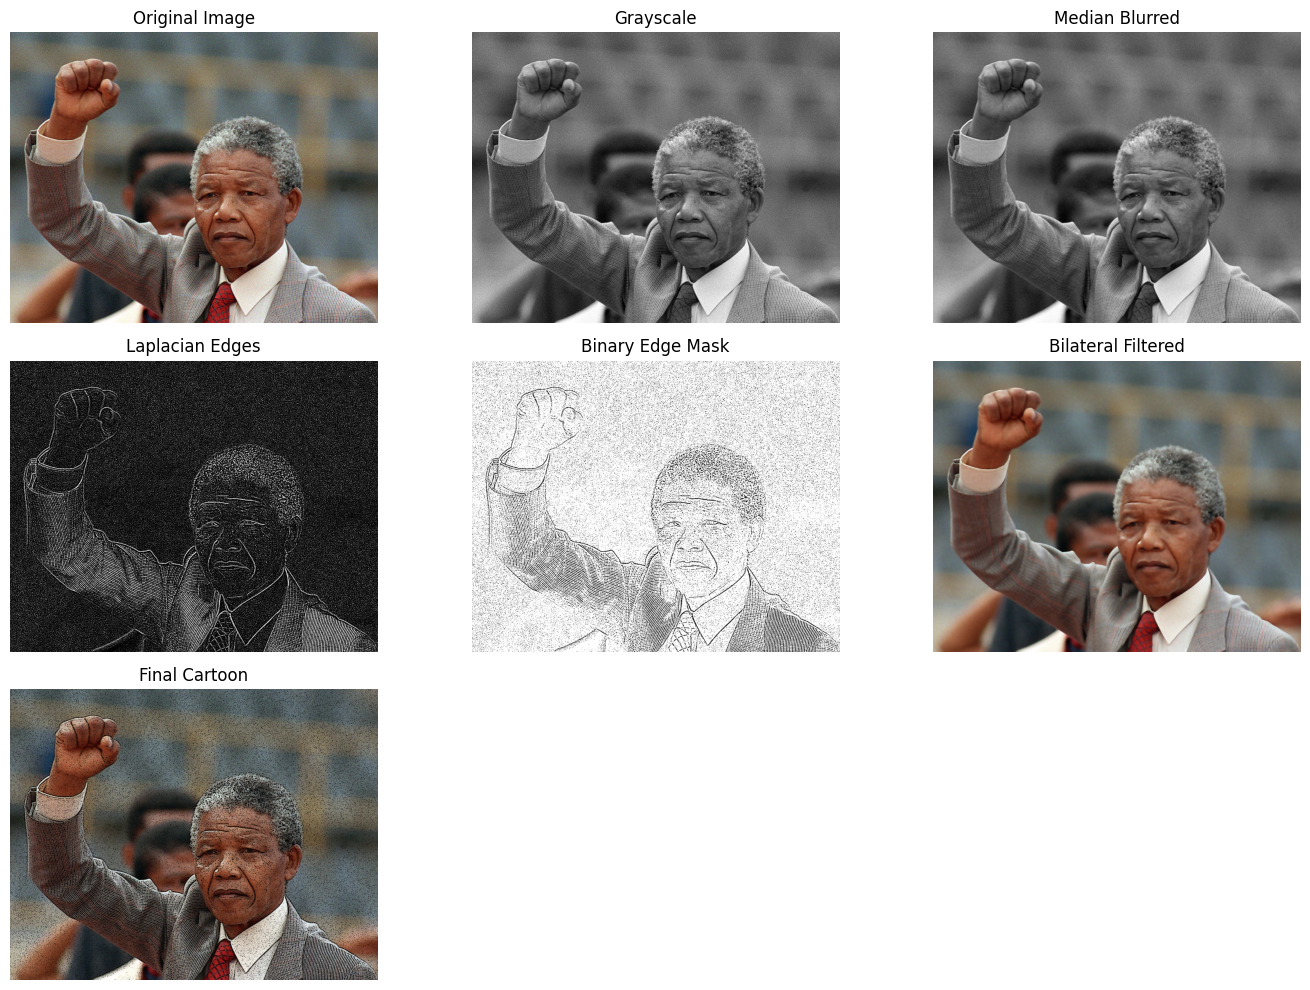

Processing robert.webp


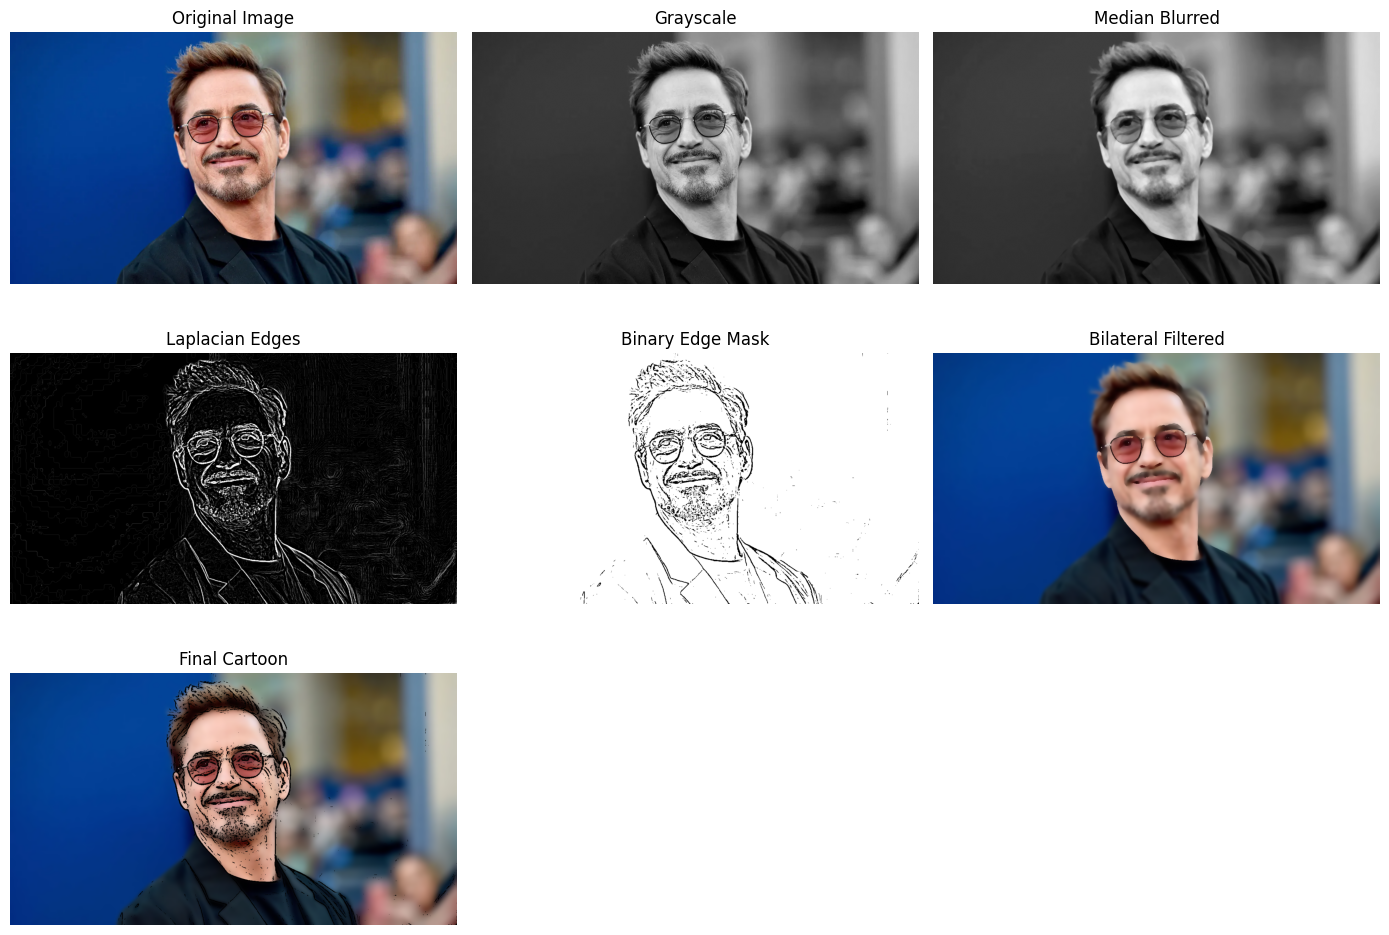

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def cartoonify_image_steps(img, 
                           median_ksize=7, 
                           laplacian_ksize=5, 
                           threshold_val=100,
                           bilateral_d=9, 
                           bilateral_sigmaColor=75, 
                           bilateral_sigmaSpace=75, 
                           num_bilateral=5):
    """
    Process the input image through several steps to obtain a cartoon effect.
    Returns a dictionary of intermediate images.
    Steps:
    1. Original image
    2. Grayscale conversion
    3. Median blurred grayscale image
    4. Laplacian filter result (raw edges)
    5. Binary edge mask (sketch)
    6. Color image after repeated bilateral filtering
    7. Final cartoon image (bilateral filtered image combined with edge mask)
    """
    steps = {}
    steps['original'] = img.copy()
    
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    
    # 2. Apply median filter to reduce noise
    gray_blur = cv2.medianBlur(gray, median_ksize)
    steps['median_blur'] = gray_blur.copy()
    
    # 3. Apply Laplacian filter for edge detection
    laplacian = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=laplacian_ksize)
    steps['laplacian'] = laplacian.copy()
    
    # 4. Apply binary thresholding to create a clear edge mask (sketch)
    ret, edge_mask = cv2.threshold(laplacian, threshold_val, 255, cv2.THRESH_BINARY_INV)
    steps['edge_mask'] = edge_mask.copy()
    
    # 5. Apply repeated bilateral filtering to smooth the color regions while preserving edges
    bilateral_img = img.copy()
    for i in range(num_bilateral):
        bilateral_img = cv2.bilateralFilter(bilateral_img, bilateral_d, bilateral_sigmaColor, bilateral_sigmaSpace)
    steps['bilateral'] = bilateral_img.copy()
    
    # 6. Combine the bilateral filtered image with the edge mask to get the final cartoon effect
    edge_mask_color = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2BGR)
    cartoon = cv2.bitwise_and(bilateral_img, edge_mask_color)
    steps['cartoon'] = cartoon.copy()
    
    return steps

def display_cartoon_steps(steps):
    """
    Displays the intermediate results for the cartoonification process.
    """
    titles = [
        "Original Image", 
        "Grayscale", 
        "Median Blurred", 
        "Laplacian Edges", 
        "Binary Edge Mask", 
        "Bilateral Filtered", 
        "Final Cartoon"
    ]
    
    images = [steps['original'], 
              steps['grayscale'], 
              steps['median_blur'], 
              steps['laplacian'], 
              steps['edge_mask'], 
              steps['bilateral'], 
              steps['cartoon']]
    
    plt.figure(figsize=(14, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)
        # Display grayscale images with a gray colormap
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_cartoonify_folder(folder_path):
    """
    Processes all images in the specified folder using the cartoonification process.
    Saves the intermediate and final outputs to a folder named "cartoon_results".
    """
    # Retrieve all image files from the folder
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))
    output_folder = 'cartoon_results'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error reading image: {image_path}")
            continue
        
        # Process the image
        steps = cartoonify_image_steps(img)
        
        # Create a base name for saving files
        base_name = os.path.splitext(os.path.basename(image_path))[0]  
        # Optionally display the results for each image.
        print(f"Processing {os.path.basename(image_path)}")
        display_cartoon_steps(steps)

if __name__ == '__main__':
    folder = 'cartoon_images'  # Folder containing your set of cartoonification input images.
    process_cartoonify_folder(folder)



Median Filter
 - What It Does:
 The median filter is a non-linear filter used primarily for noise reduction. It works exceptionally well at removing “salt and pepper” noise (random bright and dark spots) without blurring the edges as much as linear filters (like Gaussian filters) might.

 - How It Works:

  The filter works by sliding a window (kernel) over the image.
  For each pixel, it considers the intensities of the pixels in the window.
  It then replaces the center pixel’s value with the median value of those intensities.
  Because the median is less sensitive to outliers than the mean, the filter can remove noise while preserving sharp boundaries.

Laplacian Filter
 - What It Does:
 The Laplacian filter is a second-order derivative operator used for edge detection. It highlights areas of rapid intensity change in an image, which typically correspond to edges.

 - How It Works:

 The Laplacian operator computes the second derivative of the image intensity.

 This operation emphasizes regions where the intensity changes rapidly (i.e., edges).
 However, because second derivatives are highly sensitive to noise, applying the Laplacian filter directly to a noisy image could result in many false edges—hence the prior use of the median filter.
 Once the raw edges are computed, a binary threshold is applied to create a sketch-like (black-and-white) effect by converting the grayscale edges into a crisp mask where pixels are either “edge” (white) or “non-edge” (black).

 Bilateral Filter
 - What It Does:
 The bilateral filter is an edge-preserving smoothing filter. It reduces image noise and detail in flat regions while keeping edges sharp.

 - How It Works:

 Unlike traditional filters that consider only the spatial proximity of pixels, the bilateral filter combines both spatial closeness and intensity similarity.
 It applies a weighted average where weights are determined by:
 Domain (Spatial) Weight: A Gaussian function of the distance between the center pixel and the neighboring pixels.
 Range (Intensity) Weight: A Gaussian function of the difference in intensity between the center pixel and its neighbors.

## PART2 : Lane Detection

#### Hough Transform
- At its core, the Hough transform converts the problem of detecting shapes in the image (image space) into the problem of finding peaks in a parameter space. For line detection, rather than representing a line by its familiar slope–intercept form (which struggles with vertical lines), the transform uses the normal (polar) representation:

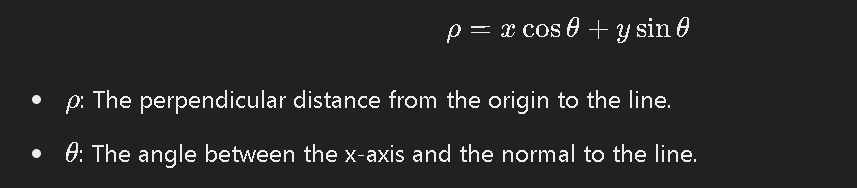

#### Step-by-Step Process
#### Step 1: Edge Detection
Before applying the Hough transform, you typically run an edge detector (such as the Canny filter) on the image to highlight the significant edge points. These edge pixels are the candidates that might belong to a line or another shape.



- canny filter :The Canny edge detector is a multi-stage algorithm designed to robustly detect edges in images while minimizing the influence of noise and ensuring accurate localization.
- In summary, the Canny edge detector:

 1. Smooths the image with a Gaussian filter to reduce noise.
 2. Computes the intensity gradients using operators like Sobel, deriving both magnitude and direction.
 3. Thins the edges using non-maximum suppression.
 4. Classifies edge pixels into strong, weak, and non-edges via double thresholding.
 5. Connects edge pixels through hysteresis, ensuring that only true edges (those connected to strong edges) remain.

#### Step 2: Mapping to Parameter Space
For each edge point 
(
𝑥
,
𝑦
)
(x,y), the algorithm computes the possible 
(
𝜌
,
𝜃
)
(ρ,θ) values for a range of angles (often 0° to 180°). Each computed pair corresponds to a line that could pass through that point.

#### Step 3: Voting in the Accumulator
An accumulator array (or voting space) is created where:

The horizontal axis represents the discretized 
𝜃
θ values.
The vertical axis represents the discretized 
𝜌
ρ values.
For each edge point and for each value of 
𝜃
θ, the corresponding 
𝜌
ρ is calculated and the cell in the accumulator at 
(
𝜌
,
𝜃
)
(ρ,θ) is incremented (i.e., “votes” for that line).

In [3]:
def manual_hough_transform(edge_image):
    height, width = edge_image.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
    rhos = np.arange(-diag_len, diag_len + 1, 1)  # ranges for rho
    thetas = np.deg2rad(np.arange(0, 180))         # ranges for theta in radians
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    edge_points = np.argwhere(edge_image != 0)       # all (y, x) coordinates where edge exists

    # Voting in Hough space (vectorized per theta)
    for theta_idx, theta in enumerate(thetas):
        # Compute rho for all edge points for the current theta
        rho_vals = edge_points[:, 1] * np.cos(theta) + edge_points[:, 0] * np.sin(theta)
        # Convert rho values to indices in the accumulator array
        rho_idxs = (rho_vals + diag_len).astype(int)
        np.add.at(accumulator, (rho_idxs, theta_idx), 1)

the previous code snippet shows how transform to the hough space and voting are executed

#### sample lane detection using cv2
we will use cv2 functions for executing the lane detection pipeline.the following function will be used
  

In [4]:
lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=hough_thresh, minLineLength=min_line_length maxLineGap=max_line_gap)
  

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2806539204.py, line 1)

- roi_edges:
The binary edge image (often from Canny) used as input.

- rho=1:
The resolution of the distance 
𝜌
ρ (in pixels) from the origin to the line. A value of 1 means increments of 1 pixel.

- theta=np.pi/180:
The angular resolution (in radians). Here, 
- 𝜋
/
180
corresponds to 1° increments.

- threshold:
The minimum number of votes a candidate line needs to be detected. Higher values return only the strongest lines.

- minLineLength:
The minimum length (in pixels) of a line segment to be accepted. Shorter segments are ignored.

- maxLineGap:
The maximum allowed gap (in pixels) between line segments to connect them as one line.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def sample_lane_detection(image, median_ksize=7, canny_thresh1=60, canny_thresh2=160, 
                          hough_thresh=50, min_line_length=50, max_line_gap=150):
    steps = {}
    steps['original'] = image
    
    # 1. Smooth the image using a median filter.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray
    
    # 3. Detect edges using the Canny edge detector.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges
    
    # Define a static (fixed) trapezoidal ROI.
    height, width = edges.shape
    polygon = np.array([[
        (int(0.2 * width), height),             # Bottom left
        (int(0.2 * width), int(0.6 * height)),   # Top left
        (int(0.8 * width), int(0.6 * height)),   # Top right
        (int(0.8 * width), height)                # Bottom right
    ]], np.int32)
    steps['static_roi_vertices'] = polygon  # vertices (for reference)
    
    # 5. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, [polygon], 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_static'] = roi_edges
    
    # 6. Detect lane lines using Hough Transform.
    lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    steps['lane_detection_static'] = lane_img
    
    return steps




In [3]:
def display_lane_detection(image_path, median_ksize=7, canny_thresh1=60, canny_thresh2=160, 
                           hough_thresh=50, min_line_length=50, max_line_gap=150):
    """
    Reads an image from image_path, applies lane detection, and plots the intermediate results.
    
    Parameters:
      image_path (str): Path to the input image.
      median_ksize (int): Kernel size for the median blur.
      canny_thresh1 (int): First threshold for the Canny edge detector.
      canny_thresh2 (int): Second threshold for the Canny edge detector.
      hough_thresh (int): Minimum number of votes for a line in Hough transform.
      min_line_length (int): Minimum line length for Hough transform.
      max_line_gap (int): Maximum allowed gap between line segments.
    """
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image from", image_path)
        return
    
    # Process the image using the lane detection function.
    steps = sample_lane_detection(image, median_ksize, canny_thresh1, canny_thresh2, 
                                    hough_thresh, min_line_length, max_line_gap)
    
    # Titles for each step output
    titles = {
        'original': "Original Image",
        'smoothed': "Median Blurred Image",
        'grayscale': "Grayscale Image",
        'edges': "Canny Edges",
        'roi_edges_static': "Edges with Static ROI Mask",
        'lane_detection_static': "Detected Lane Lines"
    }
    
    # Keys for the steps to plot
    keys = ['original', 'smoothed', 'grayscale', 'edges', 'roi_edges_static', 'lane_detection_static']
    num_images = len(keys)
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))
    for i, key in enumerate(keys):
        plt.subplot(rows, cols, i+1)
        # Convert BGR images to RGB for displaying
        if key in ['original', 'smoothed', 'lane_detection_static']:
            plt.imshow(cv2.cvtColor(steps[key], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(steps[key], cmap='gray')
        plt.title(titles[key])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
image_path = 'road1.jpg'
display_lane_detection(image_path)

Error: Could not read image from road1.jpg


#### Using Custom Built Function

In [4]:
def manual_hough_transform(edge_image):
    height, width = edge_image.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
    rhos = np.arange(-diag_len, diag_len + 1, 1)  # ranges for rho
    thetas = np.deg2rad(np.arange(0, 180))         # ranges for theta in radians one degree step size
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    edge_points = np.argwhere(edge_image != 0)       # all (y, x) coordinates where edge exists

    # Voting in Hough space (vectorized per theta)
    for theta_idx, theta in enumerate(thetas):
        # Compute rho for all edge points for the current theta
        rho_vals = edge_points[:, 1] * np.cos(theta) + edge_points[:, 0] * np.sin(theta)
        # Convert rho values to indices in the accumulator array
        rho_idxs = (rho_vals + diag_len).astype(int)
        np.add.at(accumulator, (rho_idxs, theta_idx), 1)

    # Normalize theta and rho to the range [0, 1] for plotting purposes.
    theta_normalized = (thetas - thetas.min()) / (thetas.max() - thetas.min())
    rho_normalized = (rhos - rhos.min()) / (rhos.max() - rhos.min())

    plt.figure(figsize=(5, 4))
    plt.imshow(accumulator, cmap='hot', aspect='auto')
    
    # Create tick labels based on the normalized values
    num_ticks = 10  # number of ticks to display on each axis
    theta_ticks = np.linspace(0, len(thetas) - 1, num_ticks, dtype=int)
    theta_tick_labels = np.round(theta_normalized[theta_ticks], 2)
    rho_ticks = np.linspace(0, len(rhos) - 1, num_ticks, dtype=int)
    rho_tick_labels = np.round(rho_normalized[rho_ticks], 2)

    plt.xticks(theta_ticks, theta_tick_labels)
    plt.yticks(rho_ticks, rho_tick_labels)
    plt.xlabel("Normalized Theta")
    plt.ylabel("Normalized Rho")
    plt.title("Hough Transform Accumulator with Vote Counts")
    
   
    plt.colorbar(label='Vote Count')
    plt.show()
    
    return accumulator, rhos, thetas


In [5]:


def non_maximum_suppression(accumulator, threshold=50, neighborhood_size=5):
    peaks = []
    acc_copy = accumulator.copy()

    for r_idx in range(acc_copy.shape[0]):
        for t_idx in range(acc_copy.shape[1]):
            if acc_copy[r_idx, t_idx] < threshold:
                continue
            #ensure bounds
            min_r = max(r_idx - neighborhood_size, 0)
            max_r = min(r_idx + neighborhood_size + 1, acc_copy.shape[0])
            min_t = max(t_idx - neighborhood_size, 0)
            max_t = min(t_idx + neighborhood_size + 1, acc_copy.shape[1])
            
            if acc_copy[r_idx, t_idx] == np.max(acc_copy[min_r:max_r, min_t:max_t]):
                peaks.append((r_idx, t_idx))
                acc_copy[min_r:max_r, min_t:max_t] = 0
    
    return peaks

from shapely.geometry import LineString, Polygon
import numpy as np

def clip_line_to_polygon(pt1, pt2, polygon_points):
    """
    Clips a line segment (pt1, pt2) to lie within the polygon.
    
    Parameters:
        pt1, pt2 (tuple): Endpoints of the line segment.
        polygon_points (np.ndarray): Array of polygon vertices with shape (1, N, 2)
        
    Returns:
        tuple: Clipped endpoints as ((x1, y1), (x2, y2)) or None if no intersection.
    """
    # Reshape the polygon points to a 2D array if needed.
    poly = Polygon(polygon_points.reshape(-1, 2))
    line = LineString([pt1, pt2])
    intersection = line.intersection(poly)
    
    if intersection.is_empty:
        return None
    
    # If the intersection is a LineString, extract its endpoints.
    if intersection.geom_type == 'LineString':
        coords = list(intersection.coords)
        return (int(coords[0][0]), int(coords[0][1])), (int(coords[-1][0]), int(coords[-1][1]))
    
    # If multiple segments are returned, choose the longest.
    elif intersection.geom_type == 'MultiLineString':
        longest = max(intersection, key=lambda ls: ls.length)
        coords = list(longest.coords)
        return (int(coords[0][0]), int(coords[0][1])), (int(coords[-1][0]), int(coords[-1][1]))
    
    return None

def get_hough_lines(peaks, rhos, thetas, image_shape, polygon, 
                    line_length_factor=0.01, min_line_length=50):
    """
    Convert peaks from the Hough accumulator into line segments and clip them
    to the polygon ROI.
    """
    height, width = image_shape[:2]
    diag = np.ceil(np.sqrt(height**2 + width**2))
    base_length = diag * line_length_factor
    lines = []
    
    if not peaks:
        print("Warning: No peaks detected. Try lowering the threshold in non_maximum_suppression.")
    
    for (rho_idx, theta_idx) in peaks:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        #calculating components of normal vector 
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho # point on perpendicular
        y0 = b * rho
        
        #e3ks w e2lb -b/a --->slope of the line
        pt1 = (int(x0 + base_length * (-b)), int(y0 + base_length * (a)))
        pt2 = (int(x0 - base_length * (-b)), int(y0 - base_length * (a)))
        
        # Calculate the Euclidean distance between endpoints.
        length = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Discard if the segment is shorter than the minimum.
        if length < min_line_length:
            continue
        
        # Here you would clip the line to your polygon using your clipping logic.
        # For example, you might call a clipping function:
        clipped = clip_line_to_polygon(pt1, pt2, polygon)
        if clipped is not None:
            pt1, pt2 = clipped
        else:
            continue
        
        lines.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    return lines


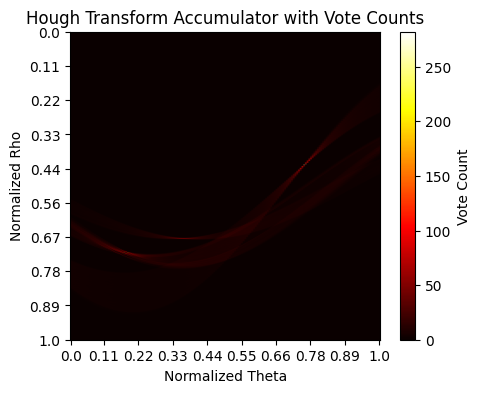

[(104, 396, 214, 345), (236, 576, 386, 345), (250, 576, 400, 345)]


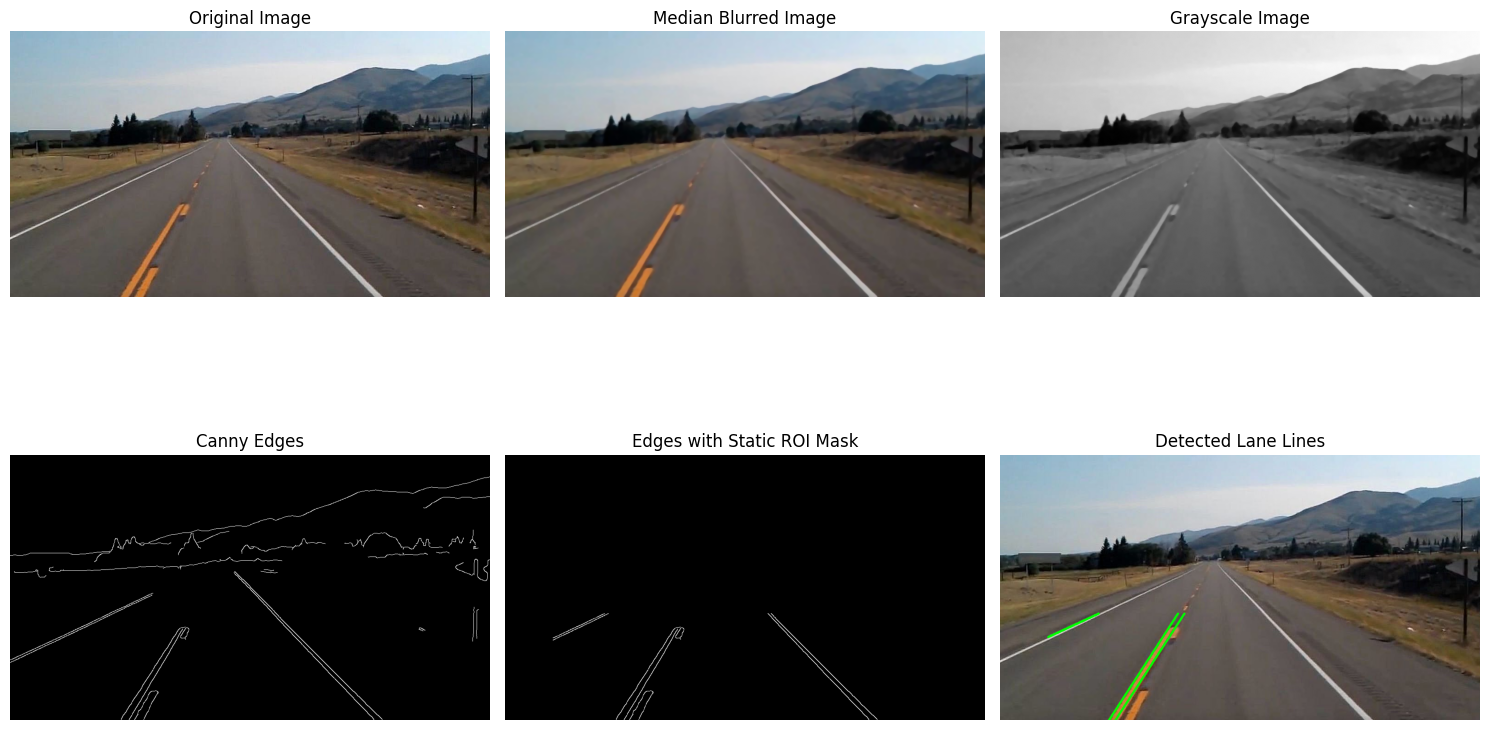

In [17]:
def custom_built_lane_detection(image, median_ksize=9, canny_thresh1=60, canny_thresh2=160, 
                          hough_thresh=50, min_line_length=100, max_line_gap=50):
    steps = {}
    steps['original'] = image
    
    # 1. Smooth the image using a median filter.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray
    
    # 3. Detect edges using the Canny edge detector.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges
    
    # Define a static (fixed) trapezoidal ROI.
    height, width = edges.shape
    polygon = np.array([[
        (int(0.1 * width), height),             # Bottom left
        (int(0.1 * width), int(0.6 * height)),   # Top left
        (int(0.8 * width), int(0.6 * height)),   # Top right
        (int(0.8 * width), height)                # Bottom right
    ]], np.int32)
    steps['static_roi_vertices'] = polygon  # vertices (for reference)
    
    # 5. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, [polygon], 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_static'] = roi_edges
    
    #6. line detection and voting
    accumulator, rhos, thetas = manual_hough_transform(roi_edges)
    peaks = non_maximum_suppression(accumulator, hough_thresh, neighborhood_size=9)
     # IMPORTANT: Pass the polygon to the get_hough_lines function.
    lines = get_hough_lines(peaks, rhos, thetas, image.shape, polygon,line_length_factor=0.5, min_line_length=min_line_length
                            )
    print(lines)

    
    lane_img = image.copy()
    if lines:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    else:
        cv2.polylines(lane_img, [polygon], True, (255, 0, 0), 2)
        
    steps['lane_detection_static'] = lane_img
    
    return steps

    
   


def display_lane_detection_custom_code(image_path, median_ksize=7, canny_thresh1=60, canny_thresh2=200, 
                           hough_thresh=40, min_line_length=10, max_line_gap=10):
    """
    Reads an image from image_path, applies lane detection, and plots the intermediate results.
    
    Parameters:
      image_path (str): Path to the input image.
      median_ksize (int): Kernel size for the median blur.
      canny_thresh1 (int): First threshold for the Canny edge detector.
      canny_thresh2 (int): Second threshold for the Canny edge detector.
      hough_thresh (int): Minimum number of votes for a line in Hough transform.
      min_line_length (int): Minimum line length for Hough transform.
      max_line_gap (int): Maximum allowed gap between line segments.
    """
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image from", image_path)
        return
    
    # Process the image using the lane detection function.
    steps = custom_built_lane_detection(image, median_ksize, canny_thresh1, canny_thresh2, 
                                    hough_thresh=hough_thresh, min_line_length=min_line_length, max_line_gap=max_line_gap)
    
    # Titles for each step output
    titles = {
        'original': "Original Image",
        'smoothed': "Median Blurred Image",
        'grayscale': "Grayscale Image",
        'edges': "Canny Edges",
        'roi_edges_static': "Edges with Static ROI Mask",
        'lane_detection_static': "Detected Lane Lines"
    }
    
    # Keys for the steps to plot
    keys = ['original', 'smoothed', 'grayscale', 'edges', 'roi_edges_static', 'lane_detection_static']
    num_images = len(keys)
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))
    for i, key in enumerate(keys):
        plt.subplot(rows, cols, i+1)
        # Convert BGR images to RGB for displaying
        if key in ['original', 'smoothed', 'lane_detection_static']:
            plt.imshow(cv2.cvtColor(steps[key], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(steps[key], cmap='gray')
        plt.title(titles[key])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
image_path = 'assign.jpg'
display_lane_detection_custom_code(image_path)

## Lane Detection on a seires of test images and parameter tuning

Processing image: road1.jpg


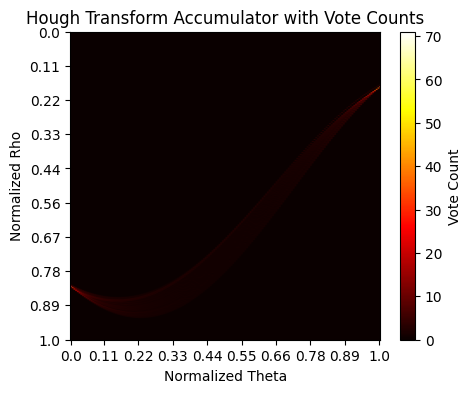

[(422, 216, 424, 317), (419, 216, 424, 302), (424, 324, 424, 216)]


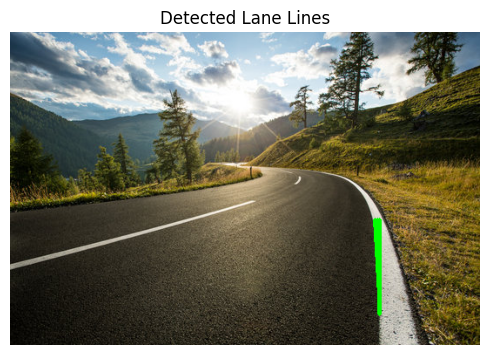

Processing image: road10.jpg


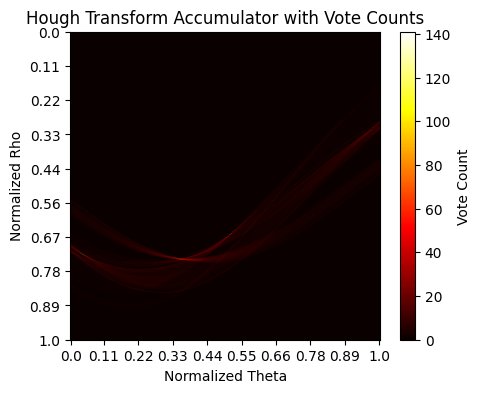

[(632, 511, 648, 726), (628, 511, 646, 715), (626, 511, 647, 705), (621, 511, 644, 696), (617, 511, 642, 686), (723, 511, 743, 512), (695, 511, 752, 513), (475, 511, 760, 516), (128, 514, 769, 514), (128, 524, 778, 513), (128, 533, 758, 511), (589, 812, 610, 511), (587, 823, 614, 511), (585, 835, 619, 511), (583, 846, 624, 511), (578, 853, 626, 511), (128, 749, 575, 511), (128, 754, 626, 511)]


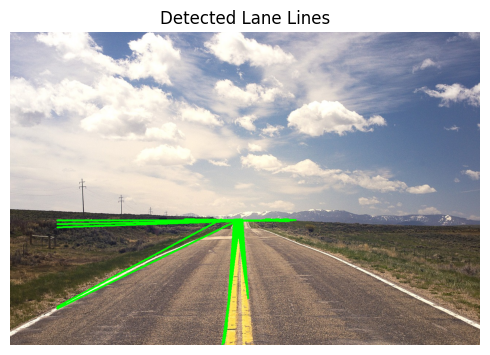

Processing image: road5.jpg


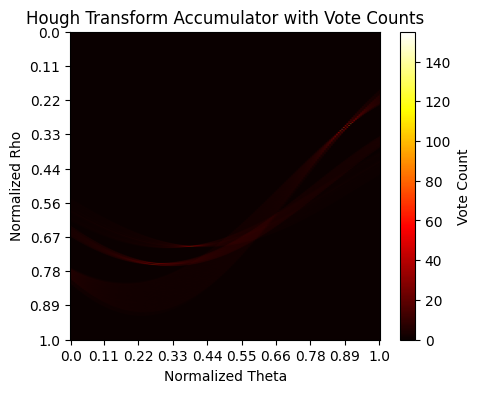

[(614, 384, 621, 404), (612, 384, 617, 397), (96, 444, 262, 384), (176, 640, 450, 384)]


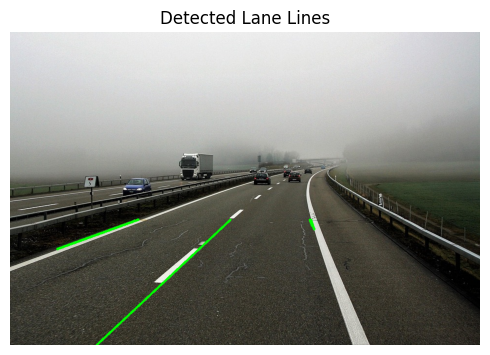

Processing image: road8.jpg


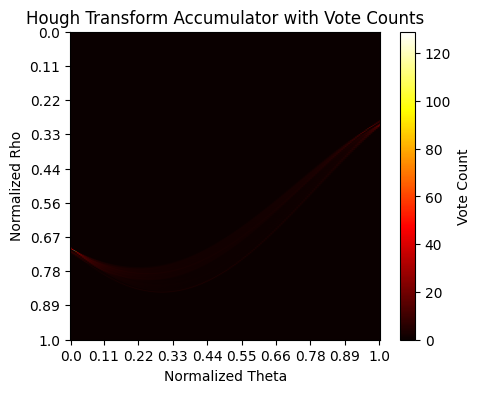

[(485, 384, 505, 504), (463, 593, 470, 384), (463, 602, 474, 384)]


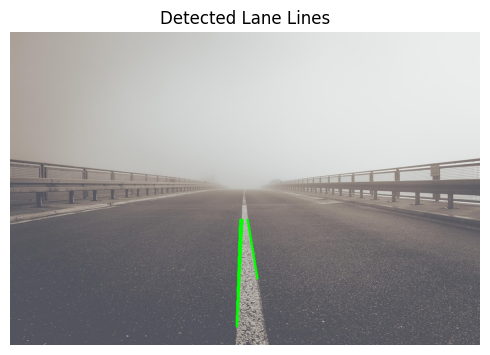

Processing image: road9.jpg


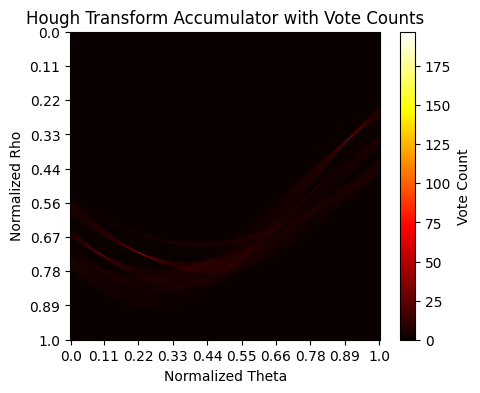

[(544, 432, 554, 465), (540, 432, 549, 459), (535, 432, 543, 454), (542, 432, 545, 440), (541, 432, 542, 434), (96, 454, 146, 432), (346, 704, 414, 432), (96, 702, 323, 432), (341, 720, 424, 432), (96, 690, 336, 432), (326, 720, 425, 432), (96, 685, 349, 432)]


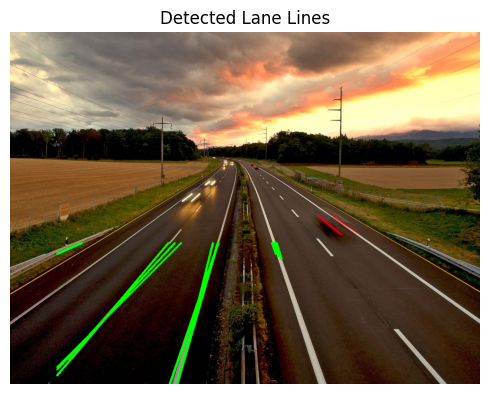

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def display_lane_detection_custom_code(image_path, median_ksize=15, canny_thresh1=60, canny_thresh2=160, 
                                         hough_thresh=40, min_line_length=100, max_line_gap=20):
    """
    Reads an image from image_path, processes it using custom_built_lane_detection,
    and displays only the final result (lane_detection_static) using matplotlib.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image from", image_path)
        return
    
    # Process the image using your custom lane detection function.
    # (Assumes custom_built_lane_detection is defined elsewhere.)
    steps = custom_built_lane_detection(image, median_ksize, canny_thresh1, canny_thresh2, 
                                        hough_thresh, min_line_length, max_line_gap)
    
    # Get the final processed image (only the last key)
    result_img = steps['lane_detection_static']
    
    plt.figure(figsize=(5, 4))
    # Convert BGR to RGB for proper display
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lane Lines")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_lane_images_folder(folder_path):
    """
    Processes all images in the specified folder and displays the final lane detection
    output for each image.
    """
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))
    
    for image_path in image_paths:
        print(f"Processing image: {os.path.basename(image_path)}")
        display_lane_detection_custom_code(image_path)

if __name__ == '__main__':
    folder = 'road_images'  # Folder containing your set of road images.
    process_lane_images_folder(folder)
